# Adaptive RAG

### 주요 학습 주제

#### 1. Intent Classification & Complexity Analysis
> **유저 질의 의도 분류 및 복잡도 기반 라우팅**
- 질문 복잡도(simple/medium/complex)를 자동 분류하여 최적 전략 선택
- 단순 질문 → no-retrieval 또는 경량 검색(K=2)
- 중간 질문 → 단일 스텝 검색 + 그레이딩
- 복잡 질문 → 반복 검색 + 쿼리 분해

#### 2. Query Transformation (HyDE, Rewrite 등 User Input 을 시스템에 맞게 변형하는 것)
> **질문과 문서 간 더 정확한 검색을 위한 질문 변형 기법들**
- **HyDE(Hypothetical Document Embeddings)**: 가설 답변 생성 → 임베딩 → 검색 시드
  > 실무에서는 쓸모 없는 경우가 대부분입니다.
- **Query Rewrite(Query Construction)**: 질의 정제 및 다변형 질의 생성 → TOP-K 융합
  > 검색 정확도 향상 및 의미적 차이를 해소

#### 3. 라우팅 전략 및 Fallback 보장
> **다양한 라우팅 구현 방법과 탈출 방지**
- **프롬프트 기반 라우팅**: LLM Structured Output(JSON)으로 경로 결정
- **툴 기반 라우팅**: Tool calling으로 노드 선택
- **Default Fallback 필수**: 모든 분기에서 최종 경로 보장 → 그래프 무한루프/탈출 방지

#### 4. Hallucination & Relevance Grading
> **답변 품질 검증 및 재시도 전략**
- 답변-근거 일치 여부 판단(환각 감지)
- 검색 문서 관련성 평가
- 실패 시 → 재검색 또는 경로 승급(single → iterative)

## 아키텍처 개요

```mermaid
flowchart TD
    A[사용자 질문 + thread_id] --> B[복잡도 분류기: gpt-4o-mini]
    B --> C{복잡도 분류}
    C -->|simple| D[no-retrieval / 직접 생성]
    C -->|medium| E[단일 검색 + 그레이딩]
    C -->|complex| F[HyDE 변형 + 검색]
    D --> G[답변 생성 with 대화 히스토리]
    E --> H[문서 검색: Qdrant docs_te3l]
    F --> I[문서 검색: Qdrant docs_te3l]
    H --> J[관련성 그레이딩]
    I --> J
    J -->|관련 있음| K[답변 생성 with 대화 히스토리]
    J -->|관련 없음| D
    K --> L[환각 검증]
    L -->|통과| M[최종 답변]
    L -->|실패 & retry < 2| H
    L -->|실패 & retry >= 2| M
    G --> M
    M --> N[Checkpointer: thread별 상태 저장]
```

### 주요 변경사항 (v2.0 - Multi-Turn 지원)

#### 1. 메모리 관리 아키텍처 변경
- **이전**: Mem0 기반 Long-Term Memory
  - 별도의 메모리 노드 (`save_memory`) 필요
  - 사용자별 메모리 저장 및 검색
- **현재**: LangGraph Checkpointer 기반 Short-Term Memory
  - Thread ID 기반 대화 히스토리 자동 관리
  - Messages 필드에 대화 내용 누적 저장
  - 노드 간 상태 자동 체크포인트

#### 2. Multi-Turn 대화 지원
- **동일 thread_id**: 이전 대화 컨텍스트 자동 로드
  - 대화 히스토리를 프롬프트에 자동 포함
  - "그것", "그거" 등 대명사 참조 해결
- **다른 thread_id**: 새로운 대화 세션 시작
  - 독립적인 컨텍스트 관리

#### 3. 그래프 플로우 최적화
- **classify 직후 조건부 라우팅**: 더 명확한 경로 선택
- **save_memory 노드 제거**: Checkpointer가 자동 관리
- **retry 로직 개선**: 환각 감지 시 retrieve로 재시도

---

## 참고문헌
- **Adaptive-RAG 논문**: [arXiv:2403.14403](https://arxiv.org/abs/2403.14403) - 질문 복잡도 기반 동적 전략 선택
- **LangChain 한국어 튜토리얼**: [위키독스 Adaptive/Agentic RAG](https://wikidocs.net/267814) - 실전 흐름 예시
- **LangGraph Adaptive RAG**: [튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag/) - Document Grader / Routing Baseline Code
- **Mem0 Self-host Quickstart**: [공식 문서](https://docs.mem0.ai/open-source/python-quickstart)


# 1. 환경 설정

In [1]:
# ============================================================================
# 환경 설정 및 초기화
# ============================================================================

import json
import os
import sys
import time
import uuid
import warnings
from pathlib import Path
from pprint import pprint

from dotenv import load_dotenv
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from qdrant_client.models import PointStruct

load_dotenv()


True

In [2]:
# ----------------------------------------------------------------------------
# OpenAI / OpenRouter 모델 초기화 헬퍼
# ----------------------------------------------------------------------------
from typing import Literal

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

load_dotenv()


def _resolve_api_context() -> tuple[str, str]:
    """선택된 API 키와 베이스 URL 정보를 반환합니다."""
    api_key = os.getenv("OPENROUTER_API_KEY")
    if not api_key:
        raise RuntimeError("OPENROUTER_API_KEY가 필요합니다.")

    base_url = os.getenv("OPENROUTER_API_BASE") or "https://openrouter.ai/api/v1"

    return (api_key, base_url)


def create_openrouter_llm(
    model: str = "openai/gpt-4.1-mini",
    temperature: float = 0.3,
    max_tokens: int | None = None,
    **kwargs: object,
) -> ChatOpenAI:
    """OpenAI 호환 LLM 생성 헬퍼.

    Args:
        model: 모델 이름. OpenRouter에서는 provider/model 형식 사용 가능
               (예: openai/gpt-4o, anthropic/claude-3-sonnet, google/gemini-pro)
        temperature: 생성 온도 (0.0-2.0)
        max_tokens: 최대 생성 토큰 수

    Returns:
        ChatOpenAI: 설정된 LLM 인스턴스
    """
    api_key, base_url = _resolve_api_context()

    openai_kwargs: dict = {
        "model": model,
        "api_key": api_key,
        "temperature": temperature,
        "max_retries": 3,
        "timeout": 60,
        **kwargs,
    }
    if max_tokens is not None:
        openai_kwargs["max_tokens"] = max_tokens
    if base_url:
        openai_kwargs["base_url"] = base_url
    return ChatOpenAI(**openai_kwargs)


def create_embedding_model(
    model: str = "openai/text-embedding-3-small",
    **kwargs,
) -> OpenAIEmbeddings:
    """OpenAI 호환 임베딩 모델 생성.

    Args:
        model: 임베딩 모델 이름. OpenRouter에서는 provider/model 형식 사용 가능
               (예: openai/text-embedding-3-small, openai/text-embedding-3-large)
        **kwargs: 추가 파라미터 (encoding_format 등은 model_kwargs로 전달됨)

    Returns:
        OpenAIEmbeddings: 설정된 임베딩 모델 인스턴스
    """
    api_key, base_url = _resolve_api_context()

    # 전달받은 kwargs에서 model_kwargs로 전달할 파라미터 분리
    # encoding_format, extra_headers 등은 model_kwargs로 전달
    model_kwargs: dict = {}
    embedding_kwargs: dict = {
        "model": model,
        "api_key": api_key,
        "show_progress_bar": True,
        "skip_empty": True,
    }

    # 전달받은 kwargs 처리
    for key, value in kwargs.items():
        # OpenRouter API 특정 파라미터는 model_kwargs로 전달
        if key in ("encoding_format"):
            model_kwargs[key] = value
        else:
            # 나머지는 OpenAIEmbeddings에 직접 전달
            embedding_kwargs[key] = value

    if base_url:
        embedding_kwargs["base_url"] = base_url

    # model_kwargs가 있으면 전달
    if model_kwargs:
        embedding_kwargs["model_kwargs"] = model_kwargs

    return OpenAIEmbeddings(**embedding_kwargs)


def create_embedding_model_direct(
    model: str = "qwen/qwen3-embedding-0.6b",
    encoding_format: Literal["float", "base64"] = "float",
    input_text: str | list[str] = "",
    **kwargs,
) -> list[float] | list[list[float]]:
    """OpenAI SDK를 직접 사용하여 임베딩 생성 (encoding_format 지원).

    LangChain의 OpenAIEmbeddings가 encoding_format을 지원하지 않을 때 사용.

    Args:
        model: 임베딩 모델 이름
        encoding_format: 인코딩 형식 ("float")
        input_text: 임베딩할 텍스트 (문자열 또는 문자열 리스트)
        **kwargs: 추가 파라미터

    Returns:
        임베딩 벡터 리스트 (단일 텍스트) 또는 리스트의 리스트 (여러 텍스트)
    """
    from openai import OpenAI

    api_key, base_url = _resolve_api_context()

    client = OpenAI(
        base_url=base_url,
        api_key=api_key,
    )

    # input_text가 비어있으면 kwargs에서 가져오기
    if not input_text:
        input_text = kwargs.get("input", "")

    response = client.embeddings.create(
        model=model,
        input=input_text,
        encoding_format=encoding_format,
    )

    # 단일 텍스트인 경우 첫 번째 임베딩 반환
    if isinstance(input_text, str):
        return response.data[0].embedding
    else:
        # 여러 텍스트인 경우 모든 임베딩 반환
        return [item.embedding for item in response.data]


def get_available_model_types() -> dict[str, list[str]]:
    """OpenRouter에서 사용 가능한 모델 유형을 반환합니다.

    Returns:
        dict[str, list[str]]: 모델 유형별 모델 목록
    """
    return {
        "chat": [
            "openai/gpt-4.1",
            "openai/gpt-4.1-mini",
            "openai/gpt-5",
            "openai/gpt-5-mini",
            "anthropic/claude-sonnet-4.5",
            "anthropic/claude-haiku-4.5",
            "google/gemini-2.5-flash-preview-09-2025",
            "google/gemini-pro-2.5",
            "x-ai/grok-4-fast",
            "moonshotai/kimi-k2-thinking",
            "liquid/lfm-2.2-6b",
            "z-ai/glm-4.6",
        ],
        "embedding": [
            "openai/text-embedding-3-small",
            "openai/text-embedding-3-large",
            "google/gemini-embedding-001",
            "qwen/qwen3-embedding-0.6b",
            "qwen/qwen3-embedding-4b",
            "qwen/qwen3-embedding-8b",
        ],
    }


embeddings = create_embedding_model()
llm = create_openrouter_llm()

## 1.1 Qdrant 로컬 실행 (Docker)

Qdrant를 로컬 Docker 컨테이너로 실행합니다.  
문서 스토어와 Mem0 메모리 스토어 모두 동일한 Qdrant 인스턴스를 사용하되 **컬렉션을 분리**합니다.

- **문서 컬렉션**: `docs_te3l`
- **메모리 컬렉션**: `mem0_user`


## 2.1 Intent Classification (의도 분류)

질문의 의도를 분류하여 적절한 처리 전략을 선택합니다.

### 왜 필요한가?
1. **적응형 처리**: 질문 유형에 따라 다른 처리 전략 사용
2. **라우팅 최적화**: 의도에 맞는 노드/파이프라인으로 라우팅
3. **사용자 경험 향상**: 정확한 의도 파악으로 더 나은 답변 제공

### 5가지 의도 유형
- **SEARCH**: 특정 정보 찾기 (조항, 섹션 등)
- **EXPLAIN**: 개념/용어 설명
- **COMPARE**: 여러 항목 비교
- **CALCULATE**: 수치 계산
- **ANALYZE**: 복합 분석 (조건부 추론, 영향 평가 등)

### Structured Output의 장점
- **타입 안전성**: Pydantic으로 구조 검증
- **일관성**: 항상 동일한 형식의 응답
- **디버깅 용이**: 명확한 스키마


In [3]:
# ============================================================================
# Intent Classification 구현
# ============================================================================

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field


# Intent Classification Output Schema
class IntentResult(BaseModel):
    """Intent Classification Result"""

    intent: Literal["SEARCH", "EXPLAIN", "COMPARE", "CALCULATE", "ANALYZE"] = Field(
        description="User question intent"
    )
    confidence: float = Field(ge=0.0, le=1.0, description="Classification confidence (0.0-1.0)")
    reasoning: str = Field(description="Classification reasoning")
    keywords: list[str] = Field(description="Extracted key keywords")


def classify_intent(query: str, llm: ChatOpenAI) -> IntentResult:
    """
    사용자 질문의 의도를 분류합니다.

    Args:
        query: 사용자 질문
        llm: LLM 모델 (ChatOpenAI)

    Returns:
        IntentResult: 의도 분류 결과 (intent, confidence, reasoning, keywords)
    """
    # Structured Output 설정
    structured_llm = llm.with_structured_output(IntentResult)
    # Intent Classification Prompt
    INTENT_CLASSIFICATION_PROMPT = """You are an intent classification expert for a legal/financial document Q&A system.
    Classify the user's question into one of the following 5 intent categories:

    **Intent Definitions**:

    1. **SEARCH**: Retrieve specific information (articles, sections, keyword search)
    - Characteristics: "What is ~?", "Find ~", "What does ~ say?"

    2. **EXPLAIN**: Explain terms/concepts, interpret legal meanings
    - Characteristics: "What does ~ mean?", "Explain ~", "Why is ~?"

    3. **COMPARE**: Compare multiple items, analyze differences
    - Characteristics: "Compare A and B", "What are the differences?", "What changed?"

    4. **CALCULATE**: Perform numerical calculations, compute amounts
    - Characteristics: "How much?", "What is the total cost?", "Calculate ~"

    5. **ANALYZE**: Complex analysis (comparison + explanation, impact assessment, conditional reasoning)
    - Characteristics: "Analyze ~", "What is the impact?", "What if ~?", "Evaluate ~"

    **Few-shot Examples**:

    Example 1 (SEARCH):
    Question: "What is the content of Article 5 in Contract A?"
    Analysis: This is a simple lookup question for a specific article (Article 5).
    → intent: SEARCH, confidence: 0.95, keywords: ["Contract A", "Article 5"]

    Example 2 (COMPARE):
    Question: "Compare the capital adequacy ratios of Bank A and Bank B"
    Analysis: This question compares financial indicators of two banks.
    → intent: COMPARE, confidence: 0.90, keywords: ["Bank A", "Bank B", "capital adequacy ratio"]

    Example 3 (ANALYZE):
    Question: "What would be the impact on our portfolio if interest rates rise?"
    Analysis: This is a complex question requiring conditional scenario analysis and impact assessment.
    → intent: ANALYZE, confidence: 0.92, keywords: ["interest rate", "rise", "portfolio", "impact"]

    **Current Question**: {query}

    Classify the intent of the question above and respond with confidence, reasoning, and keywords.
    """
    # 프롬프트 생성
    prompt = INTENT_CLASSIFICATION_PROMPT.format(query=query)

    result: IntentResult = structured_llm.invoke(prompt)

    return result


# 테스트
print("\nIntent Classification 테스트\n" + "=" * 60)

# LLM 생성 (OpenRouter 헬퍼 사용)
test_llm = create_openrouter_llm(model="gpt-4o-mini", temperature=0.0)

test_queries = [
    "계약서 A의 제5조 내용이 뭐야?",
    "자기자본비율이 무슨 뜻이야?",
    "A은행과 B은행의 자기자본비율을 비교해줘",
    "이 계약의 총 비용을 계산해줘",
    "만약 금리가 상승하면 우리 포트폴리오에 미치는 영향은?",
]

for i, query in enumerate(test_queries, 1):
    print(f"\n[질문 {i}]: {query}")
    try:
        result = classify_intent(query, test_llm)
        print(f"  → Intent: {result.intent}")
        print(f"  → Confidence: {result.confidence:.2f}")
        print(f"  → Reasoning: {result.reasoning}")
        print(f"  → Keywords: {', '.join(result.keywords)}")
    except Exception as e:
        print(f"  → 분류 실패: {e}")
    print("-" * 60)



Intent Classification 테스트

[질문 1]: 계약서 A의 제5조 내용이 뭐야?
  → Intent: SEARCH
  → Confidence: 0.95
  → Reasoning: The question is asking for specific information regarding the content of Article 5 in Contract A, which aligns with the characteristics of a SEARCH intent.
  → Keywords: 계약서 A, 제5조, 내용
------------------------------------------------------------

[질문 2]: 자기자본비율이 무슨 뜻이야?
  → Intent: EXPLAIN
  → Confidence: 0.95
  → Reasoning: The question asks for the meaning of '자기자본비율' (equity ratio), which indicates a request for an explanation of a financial term.
  → Keywords: 자기자본비율, meaning, explain
------------------------------------------------------------

[질문 3]: A은행과 B은행의 자기자본비율을 비교해줘
  → Intent: COMPARE
  → Confidence: 0.95
  → Reasoning: The question explicitly asks to compare the capital adequacy ratios of two banks (A은행 and B은행), which fits the characteristics of a comparison intent.
  → Keywords: A은행, B은행, 자기자본비율
------------------------------------------------------------

[질문

In [4]:
# ============================================================================
# Qdrant Docker 실행 및 연결 테스트
# ============================================================================
### TODO: 1~2번 실습에서 사용한 문서를 이용해야합니다.
from qdrant_client import QdrantClient

try:
    qdrant_client = QdrantClient(url="http://localhost:6333")
    collections = qdrant_client.get_collections().collections
    print(f"Qdrant 연결 성공! 현재 컬렉션 수: {len(collections)}")
    if collections:
        pprint(f"   기존 컬렉션: {[c.name for c in collections]}")
except Exception as e:
    print(f"Qdrant 연결 실패: {e}")
    print("   Qdrant가 실행 중인지 확인하세요: http://localhost:6333/dashboard")

Qdrant 연결 성공! 현재 컬렉션 수: 14
("   기존 컬렉션: ['day2_kiwi_bm25_real_test', 'day2_product', "
 "'day2_productionize_sample_collection', 'day2_int8', 'hybrid_search', "
 "'ranking_test', 'multi_vector_demo', 'day2_kiwi_bm25_hybrid', "
 "'chonkie_e2e_pipeline', 'law_docs_v1', 'mem0migrations', 'docs_te3l', "
 "'chonkie_demo', 'mem0_user']")


In [ ]:
# ============================================================================
# 문서 인덱싱 및 검색 유틸리티
# ============================================================================

### TODO: 1~2번 실습에서 사용한 문서를 이용해야합니다.


def search_documents(query: str, top_k: int = 5) -> list[dict]:
    """
    쿼리로 문서를 검색합니다.

    Args:
        query: 검색 쿼리
        top_k: 반환할 상위 문서 수

    Returns:
        검색된 문서 리스트 (text, score, metadata)
    """
    # 쿼리 임베딩
    query_vector = embeddings.embed_query(query)

    # 검색
    search_results = qdrant_client.search(
        collection_name="",  # TODO: 1~2번 실습에서 사용한 문서를 이용해야합니다.
        query_vector=query_vector,
        limit=top_k,
    )

    # 결과 포맷팅
    results = []
    for hit in search_results:
        results.append(
            {
                "text": hit.payload.get("text", ""),
                "score": hit.score,
                "metadata": {k: v for k, v in hit.payload.items() if k != "text"},
            }
        )

    return results


try:
    # indexed_count = index_documents(sample_docs)
    # print(f"{indexed_count}개 문서 인덱싱 완료")

    # 테스트 검색
    test_query = "LangChain이 무엇인가요?"
    results = search_documents(test_query, top_k=2)
    print(f"\n테스트 검색: '{test_query}'")
    for i, r in enumerate(results, 1):
        print(f"   {i}. [Score: {r['score']:.3f}] {r['text'][:80]}...")
except Exception as e:
    print(f"인덱싱/검색 실패: {e}")

  0%|          | 0/1 [00:00<?, ?it/s]

인덱싱/검색 실패: Unexpected Response: 404 (Not Found)
Raw response content:
b''


/var/folders/j_/l84vhzzn61b0tvhmqfzxn2kc0000gn/T/ipykernel_26581/491099288.py:23: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant_client.search(


## 3. 복잡도 분류기 (Complexity Classifier)

질문 복잡도를 자동으로 분류하여 적절한 RAG 전략을 선택합니다.

### 복잡도 레벨
- **simple**: 간단한 사실 질문, 인사 → no-retrieval 또는 경량 검색 (K=2)
- **medium**: 단일 주제 질문 → 단일 스텝 검색 + 그레이딩
- **complex**: 다단계 추론, 비교/분석 → 반복 검색 + 쿼리 분해 (HyDE/Rewrite)


In [10]:
# ============================================================================
# 복잡도 분류
# ============================================================================

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field


# 복잡도 분류 출력 스키마
class ComplexityClassification(BaseModel):
    """
    질문 복잡도 분류 결과

    Attributes:
        complexity: 질문 복잡도 레벨
            - "simple": 간단한 사실 질문, 인사
            - "medium": 단일 주제 질문
            - "complex": 다단계 추론, 비교/분석
        route: 라우팅 경로 구분
            - "no_retrieval": 검색 없이 직접 생성
            - "single_retrieval": 단일 검색 + 그레이딩
            - "iterative_retrieval": 반복 검색 + 쿼리 분해
    """

    complexity: Literal["simple", "medium", "complex"] = Field(
        description="질문 복잡도 레벨 (simple/medium/complex)"
    )
    reasoning: str = Field(
        description="분류 근거 (간단한 설명)"
    )  # 실전에선 절대로 reasoning 출력하지 마세요 -> 토큰 낭비
    route: Literal["no_retrieval", "single_retrieval", "iterative_retrieval"] = Field(
        description="라우팅 경로 구분 (no_retrieval/single_retrieval/iterative_retrieval)"
    )


classifier_llm = create_openrouter_llm(
    model="openai/gpt-4.1", temperature=0.0
).with_structured_output(ComplexityClassification, method="function_calling")


def classify_question(question: str) -> ComplexityClassification:
    """
    질문의 복잡도를 분류하여 적절한 RAG 전략을 선택합니다.

    이 함수는 질문의 복잡도를 분석하여 다음 3가지 레벨로 분류합니다:
    - simple: 간단한 사실 질문, 인사 → no-retrieval 또는 경량 검색 (K=2)
    - medium: 단일 주제 질문 → 단일 스텝 검색 + 그레이딩
    - complex: 다단계 추론, 비교/분석 → 반복 검색 + 쿼리 분해 (HyDE/Rewrite)

    Args:
        question: 사용자 질문 문자열

    Returns:
        ComplexityClassification: 복잡도 분류 결과 객체
            - complexity: 질문 복잡도 레벨 (simple/medium/complex)
            - route: 라우팅 경로 (no_retrieval/single_retrieval/iterative_retrieval)

    Example:
        >>> result = classify_question("LangChain이 무엇인가요?")
        >>> print(result.complexity)  # "medium"
        >>> print(result.route)  # "single_retrieval"
    """
    # Classification Prompt
    classification_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are an expert in analyzing question complexity.

    Analyze the question and classify it into one of the following 3 complexity levels:

    1. **simple**:
    - Greetings, thanks, simple confirmation questions
    - Simple factual questions (answerable in one sentence)
    - Example: "Hello", "What is LangChain?", "What is the weather today?"
    → route: 'no_retrieval' (no retrieval needed) or 'single_retrieval' (lightweight retrieval with K=2)

    2. **medium**:
    - Requests for explanation on a single topic
    - Questions about specific concepts/features
    - Example: "What are the main features of LangChain?", "What is Adaptive RAG?"
    → route: 'single_retrieval' (single retrieval + document grading)

    3. **complex**:
    - Requires multi-step reasoning
    - Comparison/analysis/synthesis questions
    - Requires deep understanding with "how", "why"
    - Example: "What are the differences between LangChain and LangGraph?", "How do you apply Adaptive RAG in practice?"
    → route: 'iterative_retrieval' (iterative retrieval + query decomposition)

    Clearly present the classification criteria and
    accurately map the route.""",
            ),
            ("human", "Question: {question}"),
        ]
    )

    result: ComplexityClassification = classifier_llm.invoke(
        classification_prompt.format(question=question)
    )
    return result


# 테스트
print("\n복잡도 분류 테스트\n" + "=" * 60)

test_questions = [
    "안녕하세요",
    "LangChain이 무엇인가요?",
    "Adaptive RAG와 일반 RAG의 차이점과 각각의 장단점을 비교 분석해주세요.",
]

for q in test_questions:
    print(f"\n질문: {q}")
    try:
        result = classify_question(q)
        print(f"   복잡도: {result.complexity}")
        print(f"   라우트: {result.route}")
        print(
            f"   근거: {result.reasoning}"
        )  # 실전에선 절대로 reasoning 출력하지 마세요 -> 토큰 낭비
    except Exception as e:
        print(f"   분류 실패: {e}")


복잡도 분류 테스트

질문: 안녕하세요
   복잡도: simple
   라우트: no_retrieval
   근거: 인삿말(간단한 인사)에 해당하여 복잡한 답변이나 추가 정보가 필요하지 않음.

질문: LangChain이 무엇인가요?
   복잡도: simple
   라우트: no_retrieval
   근거: 이 질문은 'LangChain이 무엇인가요?'라는 단순 사실형 질문으로, 한 문장으로 답변이 가능한 주제에 대한 기초적인 정의를 묻고 있습니다. 복잡한 분석이나 다단계 추론이 필요하지 않습니다.

질문: Adaptive RAG와 일반 RAG의 차이점과 각각의 장단점을 비교 분석해주세요.
   복잡도: complex
   라우트: iterative_retrieval
   근거: 이 질문은 'Adaptive RAG'와 '일반 RAG'의 차이점을 비교하고, 각각의 장단점을 분석하라는 요구를 담고 있습니다. 이는 단순 정보 제공을 넘어서 두 개념의 특성과 효과까지 비교/분석해야 하며, 다단계 추론 및 정보 종합이 필요합니다.


## 4. 질의 변형 (Query Transformation)

검색 정확도 향상을 위한 질의 변형 기법들입니다.

### HyDE (Hypothetical Document Embeddings)
- 가설 답변을 먼저 생성 → 임베딩 → 검색 시드로 사용
- 질문-문서 간 의미적 갭 해소
 > 근데, 이건 과연 얼마나 의미가 있는지 고민해본적 있으신가요?   
 > 또, 마찬가지로 얼마나 Latency 가 걸리는지 고민해본적은 있으신지요?

### Query Rewrite
- 질의를 더 명확하고 구체적으로 재작성
- 키워드 추출 및 구조화
- 구어체 → 정형화된 표현 변환

### Multi-Query Expansion
- 하나의 질문을 여러 관점으로 확장
- 다양한 각도에서 검색하여 recall 향상
- 동의어 활용, 다른 관점/각도, 구체화/일반화


In [11]:
# ============================================================================
# 질의 변형: HyDE (Hypothetical Document Embeddings)
# ============================================================================

from langchain.messages import AIMessage

hyde_llm = create_openrouter_llm(model="openai/gpt-4.1", temperature=0.1)


def hyde_transform(question: str) -> str:
    """
    HyDE 기법으로 가설 답변을 생성합니다.

    Args:
        question: 원본 질문

    Returns:
        가설 답변 (검색 시드로 사용)
    """
    # HyDE Prompt: Generate Hypothetical Answer
    hyde_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are an expert in generating hypothetical answers to questions.

    Write a hypothetical answer (Hypothetical Document) that looks like an actual answer to the given question.
    The answer should be specific, detailed, and written like an actual document.

    **Important**: It is okay if the answer is not accurate. The goal is to create a semantic seed for retrieval.""",
            ),
            ("human", "Question: {question}\n\nAnswer:"),
        ]
    )
    hypothetical_doc: AIMessage = hyde_llm.invoke(hyde_prompt.format(question=question))
    return hypothetical_doc.content


def search_with_hyde(question: str, top_k: int = 5) -> list[dict]:
    """
    HyDE 기법을 사용하여 문서를 검색합니다.

    Args:
        question: 원본 질문
        top_k: 반환할 문서 수

    Returns:
        검색 결과 리스트
    """
    # 1. 가설 답변 생성
    hyde_doc = hyde_transform(question)

    # 2. 가설 답변으로 검색 (질문 대신)
    results = search_documents(hyde_doc, top_k=top_k)

    return results


# 테스트
print("\nHyDE 테스트\n" + "=" * 60)
test_q = "Adaptive RAG는 어떻게 동작하나요?"

print(f"원본 질문: {test_q}\n")
try:
    results, hyde_doc = search_with_hyde(test_q, top_k=2)
    print(f"생성된 Hypothetical Answer:\n{hyde_doc}\n")
    print("HyDE 검색 결과:")
    for i, r in enumerate(results, 1):
        print(f"   {i}. [Score: {r['score']:.3f}] {r['text'][:80]}...")
except Exception as e:
    print(f"HyDE 실패: {e}")


# 아쉽게도 이론적 가설은 완벽할지 모르겠지만, 실전에서 HyDE 기법을 쓸 수는 없습니다.
# 1. 너무 느리다, Cost 가 2배로 듭니다.
# 2. 너무 부정확하다, 비일관적이다.


HyDE 테스트
원본 질문: Adaptive RAG는 어떻게 동작하나요?



  0%|          | 0/1 [00:00<?, ?it/s]

HyDE 실패: Unexpected Response: 404 (Not Found)
Raw response content:
b''


/var/folders/j_/l84vhzzn61b0tvhmqfzxn2kc0000gn/T/ipykernel_26581/491099288.py:23: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant_client.search(


In [14]:
# ============================================================================
# 질의 변형: Query Rewrite(Query Construction)
# ============================================================================
from langchain_openai import ChatOpenAI


# QueryRewriteResult Pydantic 모델
class QueryRewriteResult(BaseModel):
    """Query Rewrite 결과"""

    rewritten_query: str = Field(description="재작성된 질문")
    extracted_keywords: list[str] = Field(description="추출된 핵심 키워드")
    reasoning: str = Field(description="재작성 근거")


def rewrite_query(question: str, llm: ChatOpenAI) -> QueryRewriteResult:
    """
    Query Rewrite: 질문을 검색에 최적화된 형태로 재작성합니다.

    Args:
        question: 원본 질문
        llm: LLM 모델

    Returns:
        QueryRewriteResult: 재작성된 질문과 키워드
    """
    # Query Rewrite 프롬프트
    QUERY_REWRITE_PROMPT = """You are a search query optimization expert.
    Rewrite the following question into a form more suitable for search:

    **Rewriting Principles**:
    1. Colloquial → Formal expression
    2. Ambiguous terms → Clear keywords
    3. Remove unnecessary expressions
    4. Emphasize core keywords

    **Example**:
    Original: "You know that contract we talked about before, what did it say?"
    Rewritten: "Contract main clauses content"
    Keywords: ["contract", "clauses", "content"]

    **Current Question**: {query}

    Rewrite the question above and respond with extracted_keywords and reasoning.
    """
    structured_llm = llm.with_structured_output(QueryRewriteResult)
    result: QueryRewriteResult = structured_llm.invoke(QUERY_REWRITE_PROMPT.format(query=question))
    return result


def search_with_rewrite(
    question: str,
    llm: ChatOpenAI,
    top_k: int = 5,
) -> tuple[list[dict], QueryRewriteResult]:
    """
    Query Rewrite를 사용하여 문서를 검색합니다.

    Args:
        question: 원본 질문
        llm: LLM 모델
        top_k: 반환할 문서 수

    Returns:
        tuple: (검색 결과 리스트, QueryRewriteResult)
    """
    # 1. 질의 재작성
    rewrite_result = rewrite_query(question, llm)

    # 2. 재작성된 질의로 검색
    try:
        results = search_documents(rewrite_result.rewritten_query, top_k=top_k)
    except Exception as e:
        print(f"검색 실패: {e}")
        results = []

    return results, rewrite_result


# ============================================================================
# 질의 변형: Multi-Query Expansion
# ============================================================================


# MultiQueryResult Pydantic 모델
class MultiQueryResult(BaseModel):
    """Multi-Query Expansion 결과"""

    expanded_queries: list[str] = Field(description="확장된 질문들")


def expand_query(query: str, llm: ChatOpenAI, num_queries: int = 3) -> MultiQueryResult:
    """
    Multi-Query Expansion: 질문을 여러 관점으로 확장합니다.

    Args:
        query: 원본 질문
        llm: LLM 모델
        num_queries: 생성할 질문 개수

    Returns:
        MultiQueryResult: 확장된 질문들
    """

    # Multi-Query Expansion 프롬프트
    MULTI_QUERY_EXPANSION_PROMPT = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are a search query expansion expert.
    Express the following question in {num_queries} different ways:

    **Expansion Principles**:
    1. Use synonyms
    2. Different perspectives/angles
    3. Specify/generalize

    **Example**:
    Original: "What is capital adequacy ratio?"
    Expanded:
    1. "What is the definition of capital adequacy ratio?"
    2. "What is BIS ratio?"
    3. "Explain capital adequacy ratio among bank financial soundness indicators"

    **Current Question**: {query}

    Expand the question above into {num_queries} variations.
    """,
            ),
            (
                "human",
                "Question: {query}\n\nExpanded Queries:",
            ),
        ]
    )
    structured_llm = llm.with_structured_output(MultiQueryResult)
    result: MultiQueryResult = structured_llm.invoke(
        MULTI_QUERY_EXPANSION_PROMPT.format(query=query, num_queries=num_queries)
    )
    return result


def search_with_multi_query(
    question: str,
    llm: ChatOpenAI,
    top_k: int = 5,
    num_queries: int = 3,
) -> tuple[list[dict], MultiQueryResult]:
    """
    Multi-Query Expansion을 사용하여 문서를 검색합니다.

    Args:
        question: 원본 질문
        llm: LLM 모델
        top_k: 각 쿼리당 반환할 문서 수
        num_queries: 생성할 질문 개수

    Returns:
        tuple: (검색 결과 리스트, MultiQueryResult)
    """
    # 1. 질의 확장
    expansion_result = expand_query(question, llm, num_queries=num_queries)

    # 2. 각 확장된 질의로 검색 후 결과 융합
    try:
        all_results = []
        seen_texts = set()

        for expanded_q in expansion_result.expanded_queries:
            results = search_documents(expanded_q, top_k=top_k)
            for r in results:
                text = r["text"]
                if text not in seen_texts:
                    all_results.append(r)
                    seen_texts.add(text)

        # 점수 기준 정렬
        all_results.sort(key=lambda x: x["score"], reverse=True)
    except Exception as e:
        print(f"검색 실패: {e}")
        all_results = []

    return all_results[: top_k * num_queries], expansion_result


# 테스트
print("\nQuery Rewrite 테스트\n" + "=" * 60)
test_q = "그게 뭐야?"  # 애매한 질문

# LLM 생성 (OpenRouter 헬퍼 사용)
test_llm = create_openrouter_llm(model="gpt-4o-mini", temperature=0.2)

print(f"원본 질문: {test_q}\n")
try:
    results, rewrite_result = search_with_rewrite(test_q, test_llm, top_k=2)
    print(f"재작성된 질문: {rewrite_result.rewritten_query}")
    print(f"추출된 키워드: {', '.join(rewrite_result.extracted_keywords)}")
    print(f"재작성 근거: {rewrite_result.reasoning}\n")
    print("검색 결과:")
    for i, r in enumerate(results, 1):
        print(f"   {i}. [Score: {r['score']:.3f}] {r['text'][:80]}...")
except Exception as e:
    print(f"Query Rewrite 실패: {e}")

# Multi-Query Expansion 테스트
print("\n" + "=" * 60)
print("Multi-Query Expansion 테스트\n" + "=" * 60)
test_q2 = "자기자본비율이 뭐야?"

print(f"원본 질문: {test_q2}\n")
try:
    results, expansion_result = search_with_multi_query(test_q2, test_llm, top_k=2, num_queries=3)
    print("확장된 질문들:")
    for i, expanded in enumerate(expansion_result.expanded_queries, 1):
        print(f"  {i}. {expanded}")
    print("\n융합된 검색 결과:")
    for i, r in enumerate(results, 1):
        print(f"   {i}. [Score: {r['score']:.3f}] {r['text'][:80]}...")
except Exception as e:
    print(f"Multi-Query Expansion 실패: {e}")

# Before/After 비교 예제
print("\n" + "=" * 60)
print("Before/After 비교 (구어체 질문)\n" + "=" * 60)
colloquial_query = "저번에 말했던 그 계약서 있잖아, 거기 뭐라고 써있었지?"

print("\n[Before (원본)]:")
print(f"  {colloquial_query}")

print("\n[After (Query Rewrite)]:")
try:
    rewrite_result = rewrite_query(colloquial_query, test_llm)
    print(f"  재작성: {rewrite_result.rewritten_query}")
    print(f"  키워드: {', '.join(rewrite_result.extracted_keywords)}")
except Exception as e:
    print(f"  실패: {e}")


Query Rewrite 테스트
원본 질문: 그게 뭐야?



  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/j_/l84vhzzn61b0tvhmqfzxn2kc0000gn/T/ipykernel_26581/491099288.py:23: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant_client.search(


검색 실패: Unexpected Response: 404 (Not Found)
Raw response content:
b''
재작성된 질문: Definition of that term
추출된 키워드: definition, term
재작성 근거: The original question '그게 뭐야?' is informal and vague. It has been rewritten to a more formal expression that clearly asks for the definition of a specific term, emphasizing the core keywords 'definition' and 'term'.

검색 결과:

Multi-Query Expansion 테스트
원본 질문: 자기자본비율이 뭐야?



  0%|          | 0/1 [00:00<?, ?it/s]

검색 실패: Unexpected Response: 404 (Not Found)
Raw response content:
b''
확장된 질문들:
  1. 자기자본비율의 정의는 무엇인가요?
  2. 자기자본비율이란 무엇인지 설명해 주세요.
  3. 자기자본비율이 기업의 재무 건전성에 미치는 영향은 무엇인가요?

융합된 검색 결과:

Before/After 비교 (구어체 질문)

[Before (원본)]:
  저번에 말했던 그 계약서 있잖아, 거기 뭐라고 써있었지?

[After (Query Rewrite)]:
  재작성: Contract terms and conditions
  키워드: contract, terms, conditions


## 5. Grader (Hallucination & Relevance Grading)

답변 품질을 검증하고, 필요하다면 문서를 다시 검색하거나 질의를 다시 생성하는 `재시도 전략`을 수립합니다.

### Relevance Grader (관련성 그레이더)
- 검색된 문서가 질문과 관련이 있는지 판단
- 관련 없으면 → 재검색 또는 경로 전환

### Hallucination Grader (환각 그레이더)
- 생성된 답변이 검색 문서에 근거하는지 검증
- 환각 감지 시 → 재생성 또는 "확인 불가" 명시


In [19]:
# ============================================================================
# Grader: Relevance(연관성) & Hallucination(환각)
# ============================================================================
from pydantic import BaseModel, Field


# 연관성 출력 스키마
class RelevanceGrade(BaseModel):
    """
    문서 관련성 평가 결과

    Attributes:
        is_relevant: 문서가 질문과 관련 있는지 여부(bool)
            - True: 문서가 질문의 핵심 정보욕구를 충족시키는 근거를 포함
            - False: 키워드만 공유하거나 실질적 기여가 없음
        reasoning: 판단 근거 설명 (디버깅/로깅용, 실전에서는 생략 가능)
    """

    is_relevant: bool = Field(description="문서가 질문과 관련 있는지 (True/False)")
    # 실전에선 절대로 reasoning 출력하지 마세요 -> 토큰 낭비
    reasoning: str = Field(description="판단 근거 (디버깅/로깅용, 실전에서는 생략 가능)")


grader_llm = create_openrouter_llm(model="openai/gpt-4.1", temperature=0.1)


# Hallucination(환각) 2가지
# 1) Extrinsic(외재): 문서에 없는 내용을 추가로 단정(지원되지 않음)
# 2) Intrinsic(내재): 문서 내용과 모순/왜곡(반하는 서술)
# RAG에서는 답이 문서로부터 '지원되거나(증거)' 또는 '논리적으로 함의'되는지(추론 가능성)만 검토합니다.
class HallucinationGrade(BaseModel):
    """
    환각 검증 결과

    Attributes:
        is_grounded: 답변이 문서에 근거하는지 여부
            - True: 답변의 핵심 주장들이 문서로부터 직접적으로 지원되거나 함의됨
            - False: 문서에 없는 내용을 추가하거나 문서 내용과 모순됨
        reasoning: 판단 근거 설명 (디버깅/로깅용, 실전에서는 생략 가능)
            - [EXTRINSIC] 또는 [INTRINSIC]으로 환각 유형 표시
    """

    is_grounded: bool = Field(description="답변이 문서에 근거하는지 (True/False)")
    # 실전에선 절대로 reasoning 출력하지 마세요 -> 토큰 낭비
    reasoning: str = Field(
        description="판단 근거 (디버깅/로깅용, 실전에서는 생략 가능, [EXTRINSIC]/[INTRINSIC] 유형 표시)"
    )


def grade_relevance(question: str, document: str) -> RelevanceGrade:
    """
    문서-질문 관련성을 평가합니다.

    이 함수는 RAG 파이프라인의 Document Relevance Grader로,
    주어진 질문에 비추어 볼 때 제공된 문서가 답변에 직접 기여할 증거를 제공하는지 이진 판단합니다.

    평가 기준:
    - 관련성(Relevance): 문서가 질문의 핵심 정보욕구를 충족시키는 근거를 포함하거나 강하게 함의
    - 비관련(Irrelevance): 키워드만 공유하거나 실질적 기여가 없음

    Args:
        question: 사용자 질문 문자열
        document: 검색된 문서 텍스트

    Returns:
        RelevanceGrade: 관련성 평가 결과 객체
            - is_relevant: 문서가 질문과 관련 있는지 여부 (True/False)
            - reasoning: 판단 근거 설명

    Example:
        >>> grade = grade_relevance(
        ...     "LangChain의 주요 기능은?", "LangChain은 프롬프트 관리, 체인 구성, 에이전트 구현을 지원합니다."
        ... )
        >>> print(grade.is_relevant)  # True
    """

    # --- Relevance Grader ---
    relevance_grader_llm = grader_llm.with_structured_output(RelevanceGrade)
    relevance_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are a Document Relevance Grader for the RAG pipeline.
    Make a binary judgment on whether the provided 'document' offers evidence that directly contributes to answering the given 'question'.

    [Terms/Criteria]
    - Relevance: Does the document contain or strongly entail evidence (facts, definitions, procedures, numbers, citations, etc.) that satisfies the core information need of the question?
    - Irrelevance: Only shares keywords, or provides peripheral explanations/promotions/indices without substantial contribution to solving the question, or makes no mention at all.
    - Partial Match: Cases that only partially address the core requirement (nugget) are considered irrelevant (False) by default. (Policy to increase precision)
    - Prohibition: Do not supplement with external common sense/speculation. If not grounded in the document text, do not consider it relevant.

    [Evaluation Procedure]
    1) Decompose the core requirements of the question into 1-3 atomic elements (nuggets).
    2) Check if there are passages in the document that support each element through 'direct statement' or 'strong entailment'.
    - Synonyms/paraphrases/unit conversions are allowed.
    - Mere keyword mentions, comprehensive background explanations, or only links/table of contents are not accepted.
    3) Final Judgment:
    - If the document specifically supports one or more core elements, then is_relevant=true.
    - Otherwise, is_relevant=false.

    [Output Format (JSON only)]
    ```json
    {{
        "is_relevant": true | false,
        "reasoning": "Concisely in one or two sentences. Point to document id/short passage and explain why (ir)relevant."
    }}
    ```

    [Constraints]
    - No text other than JSON.
    - Do not infer/expand document content with external knowledge.""",
            ),
            (
                "human",
                """Question: {question}
    ---
    Document: {document}""",
            ),
        ]
    )

    result: RelevanceGrade = relevance_grader_llm.invoke(
        relevance_prompt.format(question=question, document=document)
    )
    return result


def grade_hallucination(documents: list[str], answer: str) -> HallucinationGrade:
    """
    답변의 환각 여부를 검증합니다.

    이 함수는 RAG의 Hallucination Grader로,
    주어진 문서 조각들만을 사실의 기준으로 삼아,
    질의에 대한 모델의 답변이 문서에 의해 충분히 지원되는지(grounded) 판정합니다.

    환각 유형:
    - Extrinsic(외재 환각): 문서에 없는 내용을 추가로 단정하거나 추론 비약으로 만든 경우
    - Intrinsic(내재 환각): 문서 내용과 모순되거나 왜곡/오인용하여 잘못된 사실을 말한 경우
    - Grounded: 답변의 핵심 주장들이 문서로부터 직접적으로 지원되거나 명시적으로 함의됨

    Args:
        documents: 참고 문서 리스트 (문자열 리스트)
        answer: 생성된 답변 문자열

    Returns:
        HallucinationGrade: 환각 검증 결과 객체
            - is_grounded: 답변이 문서에 근거하는지 여부 (True/False)
            - reasoning: 판단 근거 설명 ([EXTRINSIC]/[INTRINSIC] 유형 표시)

    Example:
        >>> docs = ["LangChain은 프롬프트 관리, 체인 구성, 에이전트 구현을 지원합니다."]
        >>> answer = "LangChain의 주요 기능은 프롬프트 관리, 체인 구성, 에이전트 구현입니다."
        >>> grade = grade_hallucination(docs, answer)
        >>> print(grade.is_grounded)  # True
    """
    docs_text = "\n\n".join([f"[문서 {i + 1}] {doc}" for i, doc in enumerate(documents)])

    # --- Hallucination Grader ---
    hallucination_grader_llm = grader_llm.with_structured_output(HallucinationGrade)

    hallucination_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are a Hallucination Grader for RAG.
    Using only the given document fragments (context) as the standard of fact, determine whether the model's answer to the question is sufficiently grounded in the documents.

    [Term Definitions]
    - Extrinsic Hallucination: Cases where content not in the document is asserted or created through inferential leaps (lack of support).
    - Intrinsic Hallucination: Cases where incorrect facts are stated by contradicting or distorting/misquoting document content (contradiction).
    - Grounded: The core claims of the answer are directly supported by or explicitly entailed from the documents.

    [Scoring Procedure]
    1) Claim Decomposition: Identify and compress the core claims of the answer into 1-3 items.
    2) Evidence Matching: For each claim, find explicit sentences or strongly entailed portions in the document.
    - Synonyms/paraphrases/unit conversions/decimal rounding are allowed.
    - 문서에 전혀 언급이 없거나 일반상식에만 의존하면 “지원 없음(Extrinsic)”.
    - 문서 진술과 상충하면 “모순(Intrinsic)”.
    3) Final Judgment:
    - If all core claims are supported, then is_grounded=true.
    - If even one claim lacks support or contradicts, then is_grounded=false.
        - If no support, mark [EXTRINSIC] at the beginning of reasoning; if contradiction, mark [INTRINSIC] (can be omitted if no reasoning).
    4) Scope/Strictness:
    - 문서 범위를 넘는 일반 지식/상식만으로 맞을 “수도” 있는 주장도 지원이 없으면 False(Extrinsic).
    - Partial Correctness: If only some of the core claims are supported, consider it False.
    - Minor stylistic, summarization, or organizational differences are allowed, but factual value changes are not.

    [Output Format]
    - Output JSON only.
    - Schema:
    ```json
    {{
        "is_grounded": true | false,
        "reasoning": "(Can be omitted if no reasoning.) Concisely in one or two sentences. Start with [EXTRINSIC] or [INTRINSIC] to indicate type. Citations include only document id/partial passage."
    }}
    ```

    [Constraints]
    - No speculation/augmentation outside the document.
    - No text other than JSON.""",
            ),
            (
                "human",
                """Reference Documents:
    {documents}

    Generated Answer:
    {answer}

    Is this answer grounded in the reference documents?""",
            ),
        ]
    )
    result: HallucinationGrade = hallucination_grader_llm.invoke(
        hallucination_prompt.format(documents=docs_text, answer=answer)
    )
    return result


# Relevance 테스트
test_question = "LangChain의 주요 기능은?"
test_doc_relevant = "LangChain은 프롬프트 관리, 체인 구성, 에이전트 구현을 지원합니다."
test_doc_irrelevant = "오늘 날씨는 맑고 화창합니다."

print(f"질문: {test_question}")
print("\n[1]  관련 문서 테스트:")
try:
    rel_result = grade_relevance(test_question, test_doc_relevant)
    print(f"   관련성: {rel_result.is_relevant}")
    print(f"   근거: {rel_result.reasoning}")
except Exception as e:
    print(f"   실패: {e}")

print("\n[2]  무관 문서 테스트:")
try:
    irrel_result = grade_relevance(test_question, test_doc_irrelevant)
    print(f"   관련성: {irrel_result.is_relevant}")
    print(f"   근거: {irrel_result.reasoning}")
except Exception as e:
    print(f"   실패: {e}")

# Hallucination 테스트
print("\n[3]  환각 검증 테스트:")
docs = [test_doc_relevant]
grounded_answer = "LangChain의 주요 기능은 프롬프트 관리, 체인 구성, 에이전트 구현입니다."
hallucinated_answer = "LangChain은 블록체인 기술을 기반으로 합니다."

try:
    hall_result1 = grade_hallucination(docs, grounded_answer)
    print(f"   근거 있는 답변: {hall_result1.is_grounded} ({hall_result1.reasoning})")

    hall_result2 = grade_hallucination(docs, hallucinated_answer)
    print(f"   환각 답변: {hall_result2.is_grounded} ({hall_result2.reasoning})")
except Exception as e:
    print(f"   실패: {e}")

질문: LangChain의 주요 기능은?

[1]  관련 문서 테스트:
   관련성: True
   근거: The document directly lists the main features of LangChain as prompt management, chain construction, and agent implementation, which addresses the core requirement of asking for its 주요 기능.

[2]  무관 문서 테스트:
   관련성: False
   근거: The document only discusses the weather and makes no mention of LangChain or its features.

[3]  환각 검증 테스트:
   근거 있는 답변: True (답변의 핵심 주장인 'LangChain의 주요 기능이 프롬프트 관리, 체인 구성, 에이전트 구현'은 문서 1에 명시적으로 모두 언급되어 있습니다.)
   환각 답변: False ([INTRINSIC] 문서 1은 LangChain이 프롬프트 관리, 체인 구성, 에이전트 구현을 지원한다고 언급하지만, 블록체인 기술 기반이라는 내용은 없으며 오히려 사실을 왜곡하고 있습니다.)


## 6. LangGraph Adaptive RAG 오케스트레이션

LangGraph를 사용하여 전체 Adaptive RAG 워크플로우를 구성합니다.

### 라우팅 전략 비교

#### 1. Prompt 기반 라우팅 (Structured Output) - 현재 구현
- **개념**: LLM이 Pydantic 모델로 다음 노드 지정
- **장점**: 타입 안전성, 명확한 의도, 일관성
- **사용 시기**: 정해진 경로가 있는 경우 (복잡도 기반 라우팅)
- **구현**: `ComplexityClassification` 모델로 route 결정

#### 2. Tool 기반 라우팅 -> [langgraph-supervisor-py 프로젝트](https://github.com/langchain-ai/langgraph-supervisor-py)
- **개념**: LLM이 Tool을 선택하면 해당 Tool/노드로 라우팅
- **장점**: LLM의 판단을 활용, 유연한 분기
- **사용 시기**: 다양한 액션이 필요한 경우
- **구현**: Tool calling으로 노드 선택 >> **SLM 에서는 어려운 방식**

#### 3. Default Fallback
- **중요성**: 예외 상황에서도 시스템이 멈추지 않도록
- **구현**: 항상 default 경로 제공, try-except로 에러 핸들링

### 그래프 구조

```mermaid
flowchart TD
    A[START] --> B[classify: 복잡도 분류]
    B --> C[route: 라우팅 결정]
    C -->|no_retrieval| D[generate_direct]
    C -->|single_retrieval| E[retrieve]
    C -->|iterative_retrieval| F[transform_query]
    E --> G[grade_relevance]
    G --> H[generate]
    H --> I[grade_hallucination]
    F --> J[retrieve]
    J --> K[generate]
    K --> L[grade_hallucination]
    D --> M[finalize: 최종 답변]
    I --> M
    L --> M
```

### Default Fallback
모든 경로에서 최종 답변을 보장하며, 실패 시 "확인 불가" 안내와 함께 종료합니다.

In [20]:
# ============================================================================
# LangGraph State 정의
# ============================================================================

import operator
from collections.abc import Sequence
from typing import Annotated, TypedDict

from langchain_core.messages import AnyMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph


class AdaptiveRAGState(TypedDict):
    """
    Adaptive RAG 그래프 상태

    LangGraph Checkpointer를 사용하여 Multi-Turn 대화를 지원합니다.
    thread_id를 통해 대화 컨텍스트가 자동으로 관리됩니다.
    """

    # 대화 히스토리 (Checkpointer가 자동 관리)
    messages: Annotated[Sequence[BaseMessage], operator.add]

    # 현재 질문
    question: str

    # 복잡도 분류
    complexity: str  # simple/medium/complex
    route: str  # no_retrieval/single_retrieval/iterative_retrieval

    # 질의 변형
    transformed_query: str

    # 검색 결과
    documents: list[dict]

    # 생성
    answer: str

    # 그레이딩
    relevance_passed: bool
    hallucination_passed: bool

    # 재시도
    retry_count: int

    # 에러
    error: str

In [21]:
# ============================================================================
# LangGraph 노드 함수들
# ============================================================================

generator_llm = create_openrouter_llm(model="openai/gpt-4.1", temperature=0.1)


# --- 노드 1: 복잡도 분류 ---
def classify_node(state: AdaptiveRAGState) -> dict:
    """질문 복잡도를 분류합니다."""
    question = state["question"]

    classification = classify_question(question)

    return {"complexity": classification.complexity, "route": classification.route}


# --- 노드 3: 질의 변형 (complex 경로용) ---
def transform_query_node(state: AdaptiveRAGState) -> dict:
    """
    복잡한 질문을 HyDE로 변형합니다.

    프로덕션 환경에서 HyDE 사용 시 주의사항:
    1. Latency 2배 증가: 가설 답변 생성 + 실제 검색으로 인한 응답 시간 증가
       - LLM 호출 1회 추가 → 평균 1-3초 추가 지연
    2. Cost 2배 증가: LLM 호출이 한 번 더 발생하여 토큰 비용 증가
       - gpt-4o-mini 기준: 입력 토큰 $0.15/1M, 출력 토큰 $0.60/1M
       - 평균 200토큰 가설 답변 → 호출당 약 $0.0001-0.0002 추가 비용
    3. 불확실성: 가설 답변의 품질이 일관적이지 않을 수 있음
       - 도메인 특화 용어의 경우 부정확한 가설 생성 가능
       - 검색 정확도 향상 효과가 항상 보장되지 않음

    → 실무 권장사항:
      - complex 질문에만 선택적 적용 (현재 구현)
      - Query Rewrite로 대체하여 비용/속도 최적화
      - A/B 테스트로 도메인별 효과 검증 후 적용
    """
    question = state["question"]
    complexity = state.get("complexity", "")

    # complex 질문이 아니면 원본 반환
    if complexity != "complex":
        return {"transformed_query": question}

    # HyDE 프롬프트
    prompt = f"""You are an expert in generating hypothetical answers to questions.

Write a hypothetical answer (Hypothetical Document) that looks like an actual answer to the given question.
The answer should be specific, detailed, and written like an actual document.

**Important**: It is okay if the answer is not accurate. The goal is to create a semantic seed for retrieval.

Question: {question}

Hypothetical Answer:"""

    try:
        hyde_llm = create_openrouter_llm(model="gpt-4o-mini", temperature=0.2)
        response = hyde_llm.invoke(prompt)
        transformed = response.content
    except Exception as e:
        print(f"HyDE 변형 실패: {e}, 원본 질문 사용")
        transformed = question

    return {"transformed_query": transformed}


# --- 노드 4: 검색 ---
def retrieve_node(state: AdaptiveRAGState) -> dict:
    """문서를 검색합니다."""
    route = state["route"]
    question = state["question"]
    transformed = state.get("transformed_query", "")

    # 검색 쿼리 결정
    if route == "iterative_retrieval" and transformed:
        query = transformed
    else:
        query = question

    # top_k 결정
    top_k = 2 if route == "no_retrieval" else 5

    try:
        docs = search_documents(query, top_k=top_k)
    except Exception as e:
        print(f"검색 실패: {e}")
        docs = []

    return {"documents": docs}


# --- 노드 5: 관련성 그레이딩 ---
def grade_relevance_node(state: AdaptiveRAGState) -> dict:
    """
    검색된 문서의 관련성을 평가합니다.

    첫 번째 문서를 기준으로 평가하여, 관련 없는 경우 다른 경로로 fallback합니다.
    """
    question = state["question"]
    documents = state.get("documents", [])

    if not documents:
        return {"relevance_passed": False}

    # 관련성 평가 프롬프트
    doc_text = documents[0]["text"]

    prompt = f"""You are a Document Relevance Grader for the RAG pipeline.
Make a binary judgment on whether the provided document offers evidence that directly contributes to answering the given question.

[용어/기준]
- Relevance: Does the document contain or strongly entail evidence (facts, definitions, procedures, numbers, citations, etc.) that satisfies the core information need of the question?
- Irrelevance: Only shares keywords or provides no substantial contribution.

Question: {question}
---
문서: {doc_text}

Is this document relevant to the question?"""

    try:
        grader_llm = create_openrouter_llm(model="gpt-4o-mini", temperature=0.0)
        structured_llm = grader_llm.with_structured_output(RelevanceGrade, method="json_mode")
        result = structured_llm.invoke(prompt)
        passed = result.is_relevant
    except Exception as e:
        print(f"관련성 평가 실패: {e}")
        passed = False

    return {"relevance_passed": passed}


# --- 노드 6: 답변 생성 (검색 기반) ---
def generate_node(state: AdaptiveRAGState) -> dict:
    """
    검색 문서와 대화 히스토리를 기반으로 답변을 생성합니다.

    LangGraph Checkpointer가 messages를 자동으로 관리하므로,
    이전 대화 맥락을 활용하여 자연스러운 Multi-Turn 대화가 가능합니다.
    """
    question = state["question"]
    documents = state.get("documents", [])
    messages = state.get("messages", [])

    # 대화 히스토리 구성 (최근 4턴만)
    conversation_history = ""
    if len(messages) > 0:
        recent_messages = messages[-8:]  # 4턴 (각 턴 = user + assistant)
        history_parts = []
        for msg in recent_messages:
            role = "사용자" if isinstance(msg, HumanMessage) else "AI"
            history_parts.append(f"{role}: {msg.content}")
        conversation_history = "\n".join(history_parts)

    # 문서 컨텍스트 구성
    if documents:
        doc_context = "\n\n".join([f"[문서 {i + 1}] {d['text']}" for i, d in enumerate(documents)])
    else:
        doc_context = "(No search results)"

    # 프롬프트 구성
    prompt = f"""The following is the previous conversation:
{conversation_history}

Reference Documents:
{doc_context}

현재 Question: {question}

Answer the question based on the above information. Respond naturally considering the conversation context.

Answer:"""

    try:
        response = generator_llm.invoke(prompt)
        answer = response.content

        # messages에 현재 턴 추가
        new_messages = [HumanMessage(content=question), AIMessage(content=answer)]
    except Exception as e:
        answer = f"Sorry. An error occurred while generating the answer: {str(e)}"
        new_messages = [HumanMessage(content=question), AIMessage(content=answer)]

    return {"answer": answer, "messages": new_messages}


# --- 노드 7: 직접 생성 (검색 없이) ---
def generate_direct_node(state: AdaptiveRAGState) -> dict:
    """
    검색 없이 직접 답변을 생성합니다 (simple 질문용).

    대화 히스토리를 활용하여 컨텍스트를 이해합니다.
    """
    question = state["question"]
    messages = state.get("messages", [])

    # 대화 히스토리 구성
    conversation_history = ""
    if len(messages) > 0:
        recent_messages = messages[-8:]
        history_parts = []
        for msg in recent_messages:
            role = "사용자" if isinstance(msg, HumanMessage) else "AI"
            history_parts.append(f"{role}: {msg.content}")
        conversation_history = "\n".join(history_parts)

    prompt = f"""Previous Conversation:
{conversation_history}

현재 Question: {question}

Answer:"""

    try:
        response = generator_llm.invoke(prompt)
        answer = response.content

        new_messages = [HumanMessage(content=question), AIMessage(content=answer)]
    except Exception as e:
        answer = f"Failed to generate answer: {str(e)}"
        new_messages = [HumanMessage(content=question), AIMessage(content=answer)]

    return {"answer": answer, "messages": new_messages}


# --- 노드 8: 환각 그레이딩 ---
def grade_hallucination_node(state: AdaptiveRAGState) -> dict:
    """
    답변의 환각 여부를 검증합니다.

    Retry 로직: 환각 감지 시 retry_count를 증가시켜 재시도를 제어합니다.
    """
    documents = state.get("documents", [])
    answer = state.get("answer", "")
    retry_count = state.get("retry_count", 0)

    if not documents or not answer:
        return {"hallucination_passed": True, "retry_count": retry_count + 1}

    # 환각 검증 프롬프트
    docs_text = "\n\n".join([f"[문서 {i + 1}] {d['text']}" for i, d in enumerate(documents)])

    prompt = f"""You are a Hallucination Grader for RAG.
Using only the reference documents as the standard of fact, determine whether the answer is sufficiently supported by the documents.

[용어 정의]
- Extrinsic(외재 환각): 문서에 없는 내용을 추가로 단정하거나 추론 비약으로 만든 경우.
- Intrinsic(내재 환각): 문서 내용과 모순되거나 왜곡/오인용하여 잘못된 사실을 말한 경우.
- Grounded: 답변의 핵심 주장들이 문서로부터 직접적으로 지원되거나 명시적으로 함의됨.

Reference Documents:
{docs_text}

생성된 Answer:
{answer}

이 답변은 참고 문서에 근거합니까?"""

    try:
        grader_llm = create_openrouter_llm(model="gpt-4o-mini", temperature=0.0)
        structured_llm = grader_llm.with_structured_output(HallucinationGrade, method="json_mode")
        result = structured_llm.invoke(prompt)
        passed = result.is_grounded
    except Exception as e:
        print(f"환각 검증 실패: {e}")
        passed = False

    return {
        "hallucination_passed": passed,
        "retry_count": retry_count + 1 if not passed else retry_count,
    }


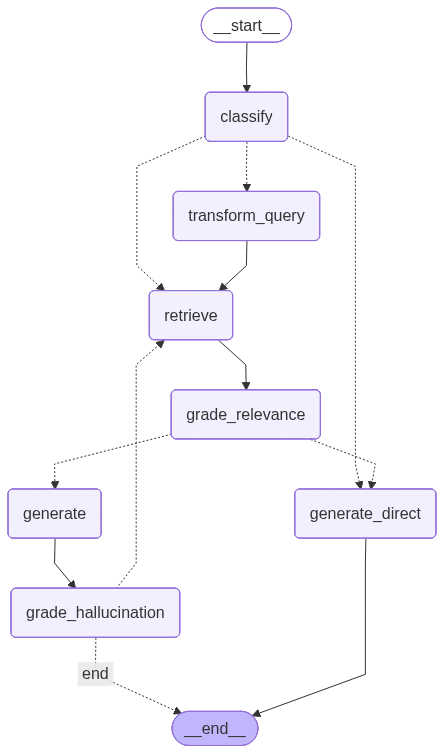

In [22]:
# ============================================================================
# LangGraph 라우팅 함수 및 그래프 구성
# ============================================================================

# --- 라우팅 함수 ---
def route_after_classify(state: AdaptiveRAGState) -> str:
    """복잡도 분류 후 경로를 결정합니다."""
    route = state["route"]

    if route == "no_retrieval":
        return "generate_direct"
    elif route == "single_retrieval":
        return "retrieve"
    elif route == "iterative_retrieval":
        return "transform_query"
    else:
        # Default fallback
        return "generate_direct"


def route_after_relevance(state: AdaptiveRAGState) -> str:
    """관련성 평가 후 경로를 결정합니다."""
    passed = state.get("relevance_passed", False)

    if passed:
        return "generate"
    else:
        # 관련 문서 없음 → 직접 생성으로 대체
        return "generate_direct"


def route_after_hallucination(state: AdaptiveRAGState) -> str:
    """
    환각 검증 후 경로를 결정합니다.

    Retry 로직: 환각 감지 시 최대 2회까지 재시도, 이후 현재 답변 반환
    """
    passed = state.get("hallucination_passed", True)
    retry_count = state.get("retry_count", 0)

    if passed:
        return "end"
    elif retry_count >= 2:
        print(f"WARNING:  재시도 한계 도달 (retry={retry_count}), 현재 답변 반환")
        return "end"
    else:
        print(f"RETRY: 환각 감지, 재검색 시도 {retry_count}/2")
        return "retrieve"


# --- 그래프 구성 ---
from langgraph.graph import END, START, StateGraph

workflow = StateGraph(state_schema=AdaptiveRAGState)

# 노드 추가
workflow.add_node("classify", classify_node)
workflow.add_node("transform_query", transform_query_node)
workflow.add_node("retrieve", retrieve_node)
workflow.add_node("grade_relevance", grade_relevance_node)
workflow.add_node("generate", generate_node)
workflow.add_node("generate_direct", generate_direct_node)
workflow.add_node("grade_hallucination", grade_hallucination_node)

# 엣지 구성
workflow.add_edge(START, "classify")

# classify 직후 조건부 라우팅
workflow.add_conditional_edges(
    "classify",
    route_after_classify,
    {
        "generate_direct": "generate_direct",
        "retrieve": "retrieve",
        "transform_query": "transform_query",
    },
)

# transform_query 후 retrieve
workflow.add_edge("transform_query", "retrieve")

# retrieve 후 관련성 평가
workflow.add_edge("retrieve", "grade_relevance")

# grade_relevance → generate or generate_direct
workflow.add_conditional_edges(
    "grade_relevance",
    route_after_relevance,
    {"generate": "generate", "generate_direct": "generate_direct"},
)

# generate 후 환각 검증
workflow.add_edge("generate", "grade_hallucination")

# grade_hallucination → END or retrieve (재시도)
workflow.add_conditional_edges(
    "grade_hallucination",
    route_after_hallucination,
    {"end": END, "retrieve": "retrieve"},
)

# generate_direct 직접 END
workflow.add_edge("generate_direct", END)

# Checkpointer 생성 (Multi-Turn 대화 관리)
# MemorySaver는 메모리에 체크포인트를 저장하여 대화 상태를 유지합니다.
# thread_id를 통해 여러 대화 세션을 독립적으로 관리할 수 있습니다.
checkpointer = MemorySaver()

# 그래프 컴파일 (Checkpointer 포함)
adaptive_rag_graph = workflow.compile(checkpointer=checkpointer)

# 그래프 시각화
adaptive_rag_graph

## 7. 그래프 실행 및 테스트

Adaptive RAG 그래프를 실행하고 다양한 복잡도의 질문으로 테스트합니다.


In [23]:
# ============================================================================
# Adaptive RAG 그래프 실행 함수
# ============================================================================


def run_adaptive_rag(question: str, thread_id: str = "default", config: dict | None = None) -> dict:
    """
    Adaptive RAG를 실행합니다.

    LangGraph Checkpointer를 통해 Multi-Turn 대화를 지원합니다.
    동일한 thread_id로 실행하면 이전 대화 컨텍스트가 자동으로 로드됩니다.

    Args:
        question: 사용자 질문
        thread_id: 대화 스레드 ID (Multi-Turn 대화 관리용)
            - 동일한 thread_id를 사용하면 이전 대화 맥락이 유지됩니다.
            - 다른 thread_id를 사용하면 새로운 대화 세션이 시작됩니다.
        config: 추가 설정 (선택)

    Returns:
        최종 상태 딕셔너리

    Example:
        >>> # Turn 1
        >>> result1 = run_adaptive_rag("LangChain이 무엇인가요?", thread_id="session_1")
        >>> # Turn 2 - "그것"이 LangChain을 가리킴
        >>> result2 = run_adaptive_rag("그것의 주요 기능은?", thread_id="session_1")
    """
    # 초기 상태
    initial_state = {
        "question": question,
        "messages": [],
        "complexity": "",
        "route": "",
        "transformed_query": "",
        "documents": [],
        "answer": "",
        "relevance_passed": False,
        "hallucination_passed": False,
        "retry_count": 0,
        "error": "",
    }

    # Config 구성
    if config is None:
        config = {}

    config["configurable"] = {"thread_id": thread_id}

    # 그래프 실행 (Checkpointer가 자동으로 이전 상태 로드)
    result = adaptive_rag_graph.invoke(initial_state, config=config)

    return result


# ============================================================================
# 단일 턴 테스트
# ============================================================================
print("=" * 80)
print("단일 턴 테스트 (각 질문은 독립적인 세션)")
print("=" * 80)

test_questions = [
    "안녕하세요!",
    "LangChain의 주요 기능은 무엇인가요?",
    "Adaptive RAG와 일반 RAG를 비교하고, 각각의 장단점을 설명해주세요.",
]

for i, q in enumerate(test_questions, 1):
    print(f"\n[질문 {i}] {q}")
    print("-" * 80)

    try:
        # 각 질문마다 다른 thread_id 사용 (독립적인 세션)
        result = run_adaptive_rag(q, thread_id=f"test_{i}")

        print(f"복잡도: {result.get('complexity', 'N/A')}")
        print(f"라우트: {result.get('route', 'N/A')}")

        if result.get("documents"):
            print(f"검색 문서: {len(result['documents'])}개")

        print(f"\n답변:\n{result.get('answer', 'N/A')}\n")

    except Exception as e:
        print(f"실행 실패: {e}\n")

단일 턴 테스트 (각 질문은 독립적인 세션)

[질문 1] 안녕하세요!
--------------------------------------------------------------------------------
복잡도: simple
라우트: no_retrieval

답변:
안녕하세요! 무엇을 도와드릴까요? 궁금한 점이나 필요한 정보가 있으시면 말씀해 주세요. 😊


[질문 2] LangChain의 주요 기능은 무엇인가요?
--------------------------------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/j_/l84vhzzn61b0tvhmqfzxn2kc0000gn/T/ipykernel_26581/491099288.py:23: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant_client.search(


검색 실패: Unexpected Response: 404 (Not Found)
Raw response content:
b''
복잡도: medium
라우트: single_retrieval

답변:
LangChain의 주요 기능은 다음과 같습니다:

1. **프롬프트 템플릿 관리**  
   다양한 LLM(대형 언어 모델)과 대화할 때 사용할 프롬프트를 쉽고 유연하게 생성, 관리할 수 있습니다.

2. **체인(Chains) 구성**  
   여러 단계를 연결해 복잡한 작업을 처리할 수 있습니다. 예를 들어 입력 → 요약 → 번역 → 출력처럼 여러 처리 과정을 체인으로 연결할 수 있습니다.

3. **에이전트(Agents) 지원**  
   외부 도구(예: 계산기, 검색 엔진 등)와 연동해 LLM이 다양한 작업을 수행하도록 돕는 에이전트를 쉽게 만들 수 있습니다.

4. **메모리 관리**  
   대화 이력(콘텍스트)을 자연스럽게 관리해 LLM 기반 챗봇과 같이 이전 대화 내용을 참고하는 어플리케이션을 만들 수 있게 해줍니다.

5. **외부 데이터와의 연동(Retrievers/VectorStores)**  
   PDF, 웹페이지, 데이터베이스 등 다양한 외부 문서나 데이터와 연동해 검색·질의·응답(RAG, Retrieval Augmented Generation) 시스템을 손쉽게 구축할 수 있습니다.

6. **풍부한 통합 및 확장성**  
   OpenAI, HuggingFace, AWS 등 다양한 LLM API 및 데이터 소스와의 통합을 기본적으로 제공합니다.

요약하자면, LangChain은 LLM을 활용한 어플리케이션(챗봇, Q&A 시스템 등)을 쉽고 빠르게 개발할 수 있도록 돕는 도구/프레임워크입니다.


[질문 3] Adaptive RAG와 일반 RAG를 비교하고, 각각의 장단점을 설명해주세요.
--------------------------------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

검색 실패: Unexpected Response: 404 (Not Found)
Raw response content:
b''
복잡도: complex
라우트: iterative_retrieval

답변:
Adaptive RAG와 일반 RAG 비교 및 각각의 장단점

**1. 일반 RAG (Retrieval-Augmented Generation)**
- **개념:**  
  일반 RAG는 사전 구축된 벡터 데이터베이스(예: FAISS, Pinecone 등)에서 쿼리와 가장 유사한 문서를 Top-K 방식으로 검색하여, 이 문서들을 컨텍스트로 활용해 LLM을 통해 답변을 생성합니다. 검색 단계(검색기, retriever)와 생성 단계(생성기, generator)가 분리되어 있지만 고정된 검색 전략(보통 절댓값 Top-K)만 사용합니다.

- **장점:**  
  - **구현이 단순하고 일관성 있음:** 엔드-투-엔드 파이프라인이 단순해 빠르게 구축 가능  
  - **일관된 성능 제공:** 검색기 성능에 따라 예측 가능  
  - **확장성:** 벡터 DB, LLM 등 개별 모듈 교체, 확장 용이

- **단점:**  
  - **비효율적 Context 활용:** 항상 K개의 문서를 고정적으로 사용하므로, 필요 없는 정보가 들어갈 때도 있고 중요한 문서를 누락할 수 있음  
  - **Query별 문서품질 편차에 대응 어려움:** 쿼리 난이도, 응답 복잡성에 따라 유연하게 대응하지 못함  
  - **Non-Adaptive:** 상황별로 검색 전략이나 컨텍스트 크기/품질을 조정하지 못함

---

**2. Adaptive RAG**
- **개념:**  
  Adaptive RAG는 쿼리의 특성, 난이도, 요구되는 답변의 정확성/복잡성 등에 따라 검색 단계나 생성 단계의 전략을 동적으로(Adaptive하게) 조정하는 RAG 확장 모델입니다.  
  - 대표적 기법: Adaptive context size(동적 컨텍스트 길이/문서 개수), confidence-based 

In [24]:
# ============================================================================
# Multi-Turn 대화 테스트
# ============================================================================
print("\n" + "=" * 80)
print("Multi-Turn 대화 테스트 (동일 thread_id로 연속 질문)")
print("=" * 80)

thread_id = "conversation_1"

# Turn 1: 초기 질문
print("\n[Turn 1]")
print("-" * 80)
q1 = "LangChain이 무엇인가요?"
print(f"질문: {q1}")

try:
    result1 = run_adaptive_rag(q1, thread_id=thread_id)
    print(f"복잡도: {result1.get('complexity', 'N/A')}")
    print(f"라우트: {result1.get('route', 'N/A')}")
    print(f"\n답변:\n{result1.get('answer', 'N/A')}\n")
except Exception as e:
    print(f"실행 실패: {e}\n")

# Turn 2: 이전 대화 컨텍스트 참조
print("\n[Turn 2]")
print("-" * 80)
q2 = "그것의 주요 기능은 뭐야?"  # "그것" = LangChain (이전 대화 참조)
print(f"질문: {q2}")
print("(이전 대화에서 '그것'이 LangChain을 가리킴)")

try:
    result2 = run_adaptive_rag(q2, thread_id=thread_id)
    print(f"복잡도: {result2.get('complexity', 'N/A')}")
    print(f"라우트: {result2.get('route', 'N/A')}")
    print(f"\n답변:\n{result2.get('answer', 'N/A')}\n")
except Exception as e:
    print(f"실행 실패: {e}\n")

# Turn 3: 추가 질문
print("\n[Turn 3]")
print("-" * 80)
q3 = "Adaptive RAG와 비교해서 설명해줘"
print(f"질문: {q3}")

try:
    result3 = run_adaptive_rag(q3, thread_id=thread_id)
    print(f"복잡도: {result3.get('complexity', 'N/A')}")
    print(f"라우트: {result3.get('route', 'N/A')}")
    print(f"\n답변:\n{result3.get('answer', 'N/A')}\n")
except Exception as e:
    print(f"실행 실패: {e}\n")

# 새로운 대화 세션 (다른 thread_id)
print("\n" + "=" * 80)
print("새로운 대화 세션 (다른 thread_id)")
print("=" * 80)

thread_id_2 = "conversation_2"

print("\n[New Thread - Turn 1]")
print("-" * 80)
q4 = "그것의 주요 기능은 뭐야?"  # 컨텍스트 없어서 "그것"을 모름
print(f"질문: {q4}")
print("(새로운 세션이므로 '그것'이 무엇인지 모름)")

try:
    result4 = run_adaptive_rag(q4, thread_id=thread_id_2)
    print(f"복잡도: {result4.get('complexity', 'N/A')}")
    print(f"라우트: {result4.get('route', 'N/A')}")
    print(f"\n답변:\n{result4.get('answer', 'N/A')}\n")
except Exception as e:
    print(f"실행 실패: {e}\n")

print("=" * 80)
print("COMPLETED: Multi-Turn 대화 테스트 완료!")
print("동일 thread_id: 이전 대화 컨텍스트 유지됨")
print("다른 thread_id: 새로운 대화 세션으로 시작됨")
print("=" * 80)



Multi-Turn 대화 테스트 (동일 thread_id로 연속 질문)

[Turn 1]
--------------------------------------------------------------------------------
질문: LangChain이 무엇인가요?
복잡도: simple
라우트: no_retrieval

답변:
LangChain은 **언어 모델(LLM, Large Language Model, 예: OpenAI의 GPT 시리즈 등)**을 활용하여 다양한 애플리케이션을 개발할 수 있도록 지원하는 파이썬 기반 오픈소스 프레임워크입니다. LangChain의 주요 목적은 LLM의 강력한 능력을 실제 업무, 애플리케이션, 서비스와 쉽게 연결할 수 있도록 돕는 것입니다.

### LangChain의 주요 특징

1. **체인(Chain) 구조**  
   LangChain은 여러 LLM 호출, 툴 사용, 데이터 처리 단계를 유연하게 이어 붙일 수 있도록 체인 형태로 구성할 수 있습니다.

2. **에이전트(Agent) 지원**  
   단순히 프롬프트만 넘기는 것이 아니라, LLM이 다양한 외부 툴(검색 엔진, 계산기, 데이터베이스 등)에 접근해 스스로 행동을 선택하도록 할 수 있습니다.

3. **다양한 데이터 소스와의 연동**  
   텍스트, 데이터베이스, 문서 등 다양한 데이터 소스와 쉽게 통합되어 LLM 기반 질문 응답, 챗봇, 검색 등의 개발에 활용할 수 있습니다.

4. **프롬프트 관리 및 템플릿**  
   프롬프트(질의 내용)의 구성과 버전을 효율적으로 관리할 수 있습니다.

### 쉽게 말해,

- LangChain은 LLM을 현업 서비스에 접목하고자 할 때, 프롬프트 설계, 툴 연동, 응답 처리 등 복잡한 작업을 간편하게 설계할 수 있도록 도와주는 도구입니다.
- 예를 들어 "PDF를 읽고 질문에 답하는 챗봇 만들기", "사내 DB와 연동된 AI 비서 만들기" 같은 프로젝트를 쉽고 빠르게 구축할 수 있도록 해줍니다.

### 

  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/j_/l84vhzzn61b0tvhmqfzxn2kc0000gn/T/ipykernel_26581/491099288.py:23: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant_client.search(


검색 실패: Unexpected Response: 404 (Not Found)
Raw response content:
b''
복잡도: medium
라우트: single_retrieval

답변:
LangChain의 주요 기능은 다음과 같습니다:

---

### 1. **체인(Chain) 구성**
- 여러 단계의 작업(프롬프트 생성, LLM 호출, 결과 가공 등)을 순차적으로 묶어서 처리할 수 있습니다.
- 예: 질문 → LLM에 전달 → 결과 요약 → 사용자에게 전달

### 2. **에이전트(Agent)**
- LLM이 다양한 외부 도구(검색, 계산, 데이터베이스 질의 등)를 스스로 선택하고 실행할 수 있는 "에이전트" 구조를 지원합니다.
- 이로써, 단순 프롬프트 답변뿐만 아니라, 외부 작업을 수행할 수 있습니다.

### 3. **프롬프트 템플릿 관리**
- 프롬프트(LLM에 전달할 입력 내용)를 템플릿으로 관리하여, 다양한 입력 상황에 맞게 쉽게 적용할 수 있습니다.
- 반복적인 프롬프트 작성의 번거로움을 줄여줍니다.

### 4. **메모리(Memory) 지원**
- 이전 대화나 작업 맥락을 기억하고 활용할 수 있게 해줍니다.
- 챗봇 같은 지속적 대화 시스템에 매우 유용합니다.

### 5. **외부 데이터 연동**
- 데이터베이스, PDF, 웹사이트, 엑셀 등 다양한 데이터 소스를 연결해 자연어로 조회, 검색, 요약 작업을 할 수 있습니다.

### 6. **Tool 및 플러그인 통합**
- 계산, 검색, API 호출 등 다양한 툴을 손쉽게 연결하여 LLM이 풍부한 기능을 발휘할 수 있도록 도와줍니다.

### 7. **워크플로우 설계**
- 복잡한 작업을 여러 단계로 나눠 체계적으로 처리하는 워크플로우를 쉽게 만들 수 있습니다.

---

**요약해서:**  
LangChain은 LLM을 중심으로 데이터 연결, 툴 통합, 대화 흐름 관리, 자동 워크플로우 설계 등을 지원해, 실무에서 다양한 AI 서비스 및 챗봇, 자동화 도구를 쉽고 빠르게 구축

  0%|          | 0/1 [00:00<?, ?it/s]

검색 실패: Unexpected Response: 404 (Not Found)
Raw response content:
b''
복잡도: complex
라우트: iterative_retrieval

답변:
네! **LangChain**과 **Adaptive RAG(Adaptive Retrieval-Augmented Generation)**의 차이를 설명하자면, 두 기술이 목표는 비슷할 수 있어도 접근 방식, 구조, 활용 방향에서 차이가 있습니다. 아래에서 각각이 무엇인지와, **LangChain vs. Adaptive RAG**의 비교 포인트를 설명해 드릴게요.

---

## 1. **LangChain이란?**
- **정의:** LLM(대형언어모델)을 실제 서비스에 활용할 때 필요한 도구/컴포넌트/단계를 연결해주는 파이프라인 및 프레임워크 (즉, 애플리케이션 개발 프레임워크)
- **포커스:** 프롬프트 설계, 데이터 소스 연결, 도구 통합, 체인 및 에이전트 구성 등 다양한 AI 워크플로우** "설계와 실행" **에 중점
- **주요 역할:** LLM 기반 애플리케이션 구성과 통합

---

## 2. **Adaptive RAG (Adaptive Retrieval-Augmented Generation)란?**
- **정의:** RAG는 Retrieval-Augmented Generation의 약자
    - **RAG:** 외부 지식(문서, DB 등)을 LLM 답변에 "첨가"하는 구조(예: ChatGPT의 웹 검색, PDF 검색 기반 답변 등)
    - **Adaptive RAG:** 한 발 더 나아가, 사용자의 질문, 상황, 맥락에 따라 "가장 적합한 검색/추론 전략"을 **동적으로** 선택하고 적응(adaptive)하는 RAG 방식
      - (예: 쉬운 질문은 단순검색, 어려운 질문은 추가로 세부 쿼리/파인튜닝/Post-processing 등 적용)
- **포커스:** LLM이 정보 검색 + 추론에 필요한 최적 방식을 **적응적으로 고르고 동적으로 

  0%|          | 0/1 [00:00<?, ?it/s]

검색 실패: Unexpected Response: 404 (Not Found)
Raw response content:
b''
복잡도: medium
라우트: single_retrieval

답변:
물어보신 "그것"이 정확히 무엇을 가리키는지 현재 대화 내용만으로는 알 수 없습니다. 이전 대화 내역을 제공해주시면, 더 정확하게 해당 기능에 대해 답변드릴 수 있습니다.  
만약 특정 제품, 앱, 서비스, 소프트웨어, 기기 등 무엇을 말씀하시는 건지 알려주시면, 그에 맞는 주요 기능을 자세히 안내해드릴 수 있습니다!

COMPLETED: Multi-Turn 대화 테스트 완료!
동일 thread_id: 이전 대화 컨텍스트 유지됨
다른 thread_id: 새로운 대화 세션으로 시작됨


## Adaptive RAG 구현 항목

1. **복잡도 분류기**: LLM 기반 질문 복잡도 분류 노드 (simple/medium/complex)
2. **질의 변형**: HyDE (complex 질문 전용) - 프로덕션 환경 고려사항 포함
3. **그레이더**: 관련성 및 환각 검증으로 답변 품질 보장
4. **LangGraph 오케스트레이션**: 복잡도 기반 동적 라우팅 및 default fallback
5. **Multi-Turn 대화**: LangGraph Checkpointer 기반 대화 컨텍스트 관리

### 주요 특징

- **Adaptive 전략**: 질문 복잡도에 따라 no-retrieval/single/iterative 자동 선택
- **품질 보장**: 관련성/환각 그레이딩으로 신뢰도 높은 답변 생성
- **Fallback**: 모든 경로에서 최종 답변 보장
- **Multi-Turn**: thread_id 기반 대화 히스토리 자동 관리

### 고려사항

#### HyDE 사용 시 주의점
- **Latency 2배**: LLM 호출 1회 추가
- **Cost 2배**: 토큰 비용 증가
- **불확실성**: 가설 답변 품질 일관성 문제
- **권장**: complex 질문에만 선택적 적용 또는 Query Rewrite로 대체(왠만해선 굳이 안쓰는게 좋습니다)

#### Checkpointer vs Long-Term Memory
- **Checkpointer (현재 구현)**: Thread 단위 Short-Term Memory
  - 장점: 구현 단순, LangGraph 네이티브 지원
  - 단점: 스레드 간 정보 공유 불가
- **Long-Term Memory (선택적)**: 사용자 단위 크로스-스레드 메모리
  - 사용 시기: 사용자 선호도, 지식 누적이 필요한 경우
  - 구현 방법: `LangGraph Store(LangMem)` 또는 `Mem0`

### 개선 방향

1. **Hybrid 검색**: BM25 + Dense retrieval 결합으로 검색 정확도 향상
2. **Long-Term Memory**: LangGraph Store 통합으로 크로스-스레드 지식 관리
3. **평가 자동화**: LangSmith/RAGAS 통합으로 지속적 성능 모니터링
4. **프로덕션 최적화**: 
   - 캐싱: 반복 질문 응답 시간 단축
   - 배치 처리: 다중 질문 동시 처리
   - 비동기 실행: asyncio 기반 성능 향상
